# BigQuery Data + Hypothesis Test

In this project, I query data with SQL from the BigQuery API. The data comes from "The Look Ecommerce" dataset, which is synthetic ecommerce data that is updated regularly.

The project will follow these steps:
   - Connect to BigQuery API
   - Query for the necessary data
   - Summarize with boxplots and tables
   - Hypothesis testing on results

In [1]:
import statistics
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import seaborn as sns
import numpy as np
import pandas as pd

## Connecting to BigQuery API

In [2]:
%load_ext google.cloud.bigquery

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account

key_path = "bigquery-example-KEY.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)

## Shipping Time by Distribution Center

I want to explore the shipping time of orders from different distribution centers. Do certain centers ship faster than others?

There are a couple parameters to limit this question:
  - only orders within the US
  - only orders from the last month

In [4]:
sql = """
with shipping as (
  select 
    user_id, 
    inventory_item_id, 
    timestamp_diff(delivered_at, shipped_at, HOUR) as shipping_time_hrs,
    shipped_at,
    product_distribution_center_id
  from 
    bigquery-public-data.thelook_ecommerce.order_items
    left join bigquery-public-data.thelook_ecommerce.inventory_items
    on order_items.inventory_item_id = inventory_items.id
  where
    status = 'Complete' # only orders that have completed shipping
    and timestamp_diff(current_timestamp(), shipped_at, DAY) <= 31 #only in the last month
),

customers as (
  select 
    id, state, country
  from
    bigquery-public-data.thelook_ecommerce.users
  where
    country = "United States" # only customers in the US
), 

distribution as (
  select * from bigquery-public-data.thelook_ecommerce.distribution_centers
)

select 
  product_distribution_center_id as distribution_center_id,
  name as distribution_center,
  shipping_time_hrs
from customers
  inner join 
    (shipping join distribution on shipping.product_distribution_center_id = distribution.id)
  on customers.id = shipping.user_id
;
"""
shipping = client.query(sql).to_dataframe()

In [5]:
shipping

,distribution_center_id,distribution_center,shipping_time_hrs
0,8,Mobile AL,117
1,2,Chicago IL,94
2,2,Chicago IL,53
3,1,Memphis TN,29
4,10,Savannah GA,103
...,...,...,...
1383,8,Mobile AL,29
1384,1,Memphis TN,70
1385,9,Charleston SC,80
1386,9,Charleston SC,36


### Summarizing Data in Boxplots

In [6]:
shipping['distribution_center'] = shipping.distribution_center.replace(
                                                        "Port Authority of New York/New Jersey NY/NJ",
                                                        value = "New York NY")

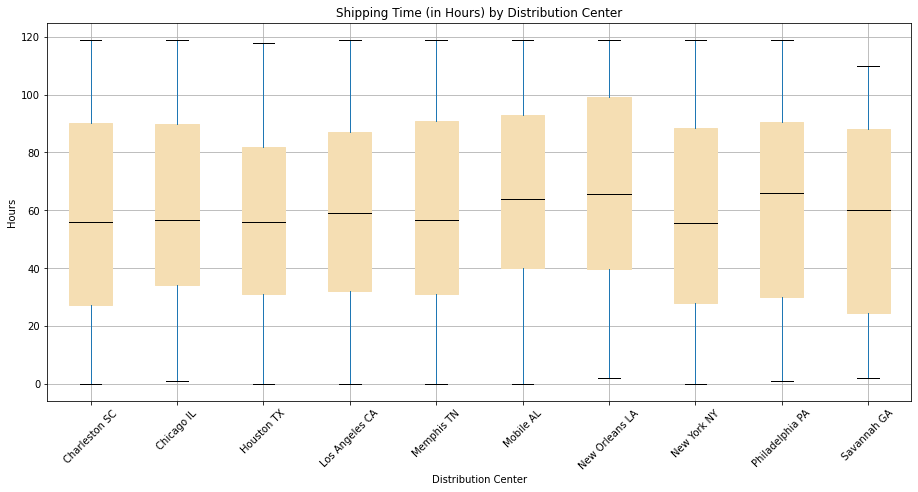

In [7]:
ax = shipping.boxplot(column='shipping_time_hrs', 
                      by="distribution_center", 
                      figsize=(15,7), rot=45,
                      patch_artist=True,
                      boxprops=dict(facecolor='wheat', color='wheat'),
                      medianprops=dict(color='k'))
ax.set_ylabel("Hours")
ax.set_xlabel("Distribution Center")
ax.set_title("Shipping Time (in Hours) by Distribution Center")
ax.get_figure().suptitle('');

### Summarizing Data in a Table

I can summarize this data in a table by two different methods to get the same results:
   1. Manipulating the data in Pandas
   2. Performing another SQL query to aggregate the results

In [8]:
# 1. Manipulating the data in Pandas
table = shipping.groupby(by=['distribution_center'])\
                        .agg(['mean', 'count'])['shipping_time_hrs']\
                        .sort_values(by=['mean'])
table['mean'] = table['mean'].apply(lambda x: round(x, 1))
table = table.rename(columns={"mean":"avg_shipping_hrs", "count":"num_orders"})
table

,avg_shipping_hrs,num_orders
distribution_center,,
Houston TX,56.8,185
Savannah GA,57.0,100
Los Angeles CA,57.7,137
New York NY,57.9,120
Charleston SC,58.0,116
Chicago IL,59.2,194
Memphis TN,59.8,174
Philadelphia PA,61.4,143
Mobile AL,62.6,115


In [9]:
# 2. Performing another SQL query to aggregate data
sql = """
with shipping as (
  select 
    user_id, 
    inventory_item_id, 
    timestamp_diff(delivered_at, shipped_at, HOUR) as shipping_time_hrs,
    shipped_at,
    product_distribution_center_id
  from 
    bigquery-public-data.thelook_ecommerce.order_items
    left join bigquery-public-data.thelook_ecommerce.inventory_items
    on order_items.inventory_item_id = inventory_items.id
  where
    status = 'Complete' # only orders that have completed shipping
    and timestamp_diff(current_timestamp(), shipped_at, DAY) <= 31 #only in the last month
),

customers as (
  select 
    id, state, country
  from
    bigquery-public-data.thelook_ecommerce.users
  where
    country = "United States" # only customers in the US
), 

distribution as (
  select * from bigquery-public-data.thelook_ecommerce.distribution_centers
)

select 
  # product_distribution_center_id as distribution_center_id,
  name as distribution_center,
  round(avg(shipping_time_hrs),1) as avg_shipping_hrs,
  count(*) as num_orders,
from customers
  inner join 
    (shipping join distribution on shipping.product_distribution_center_id = distribution.id)
  on customers.id = shipping.user_id
group by name
order by avg_shipping_hrs
;
"""
shipping_summary = client.query(sql).to_dataframe()
shipping_summary

,distribution_center,avg_shipping_hrs,num_orders
0,Houston TX,56.8,185
1,Savannah GA,57.0,100
2,Los Angeles CA,57.7,137
3,Port Authority of New York/New Jersey NY/NJ,57.9,120
4,Charleston SC,58.0,116
5,Chicago IL,59.2,194
6,Memphis TN,59.8,174
7,Philadelphia PA,61.4,143
8,Mobile AL,62.6,115
9,New Orleans LA,65.4,104


## Hypothesis Testing

Is there a statistically significant difference between the fastest and slowest distribution centers?
  - Fastest: **Houston TX**
  - Slowest: **New Orleans LA**
  
Defining the question:
   - Null hypothesis:
      - **The shipping times at the two distribution centers are the same.**
   - Alternative hypothesis: 
      - **The shipping times at the two distribution centers are not the same.** 

In [10]:
# separate Pandas series 
norleans = shipping[shipping.distribution_center=="New Orleans LA"].shipping_time_hrs.astype('int64')
houston = shipping[shipping.distribution_center=="Houston TX"].shipping_time_hrs.astype('int64')

In [11]:
# "long form" dataset to be used for plotting
compare = shipping[(shipping.distribution_center=="New Orleans LA")|(shipping.distribution_center=="Houston TX")]
compare = compare.astype({'distribution_center_id':'int64', 
                            'distribution_center':'category', 
                            'shipping_time_hrs':'int64'})

### Checking Normality

I must evaluate if the data is normally distributed.

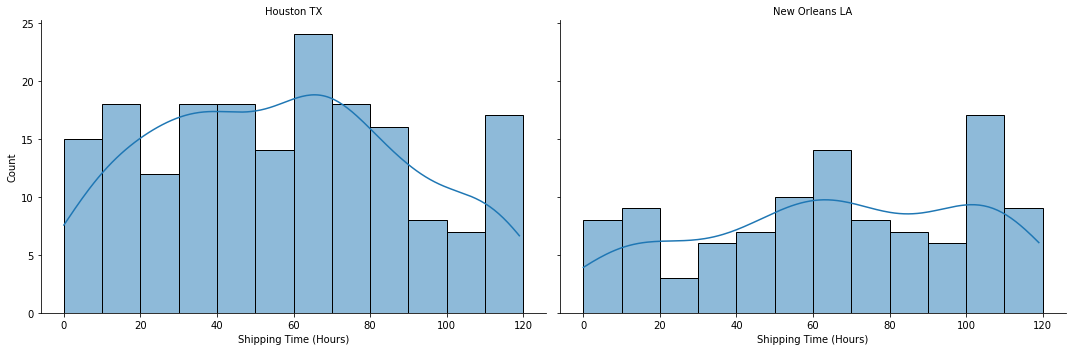

In [12]:
facet = sns.displot(data=compare, 
                    x="shipping_time_hrs", 
                    col="distribution_center", 
                    kde=True, 
                    aspect=1.5, 
                    stat='count',
                    bins = range(0,121,10))
facet.set_xlabels("Shipping Time (Hours)")
facet.set_titles("{col_name}");

In [13]:
print("Shapiro-Wilk Normality Test for HOUSTON Shipping Times:")
print(f"statistic: {shapiro(houston)[0]:.3f}")
print(f"p-value:   {shapiro(houston)[1]:.5f}")
print()

print("Shapiro-Wilk Normality Test for NEW ORLEANS Shipping Times:")
print(f"statistic: {shapiro(norleans)[0]:.3f}")
print(f"p-value:   {shapiro(norleans)[1]:.5f}")

Shapiro-Wilk Normality Test for HOUSTON Shipping Times:
statistic: 0.965
p-value:   0.00015

Shapiro-Wilk Normality Test for NEW ORLEANS Shipping Times:
statistic: 0.943
p-value:   0.00021


Visually, in the histograms with the kernel density estimations overlaid, the two distributions of shipping times do not appear to be normally distributed. 

This is supported by the results of the Shapiro-Wilk Tests. Because the p-value for each of the distributions is below the significance level of .05, we can reject the null hypothesis that they are normally distributed.

Therefore, I will use the Mann Whitney U test to test the hypothesis because:
   - the data is not normally distributed
   - the two sets are independent

### Testing

In [14]:
res = mannwhitneyu(houston, norleans)

In [15]:
print("Mann Whitney U Test for Shipping Times:")
print(f"statistic: {res[0]:.1f}")
print(f"p-value:   {res[1]:.5f}")
print()

Mann Whitney U Test for Shipping Times:
statistic: 8278.5
p-value:   0.04921



### Conclusions

Because the p-value is < .05, the null hypothesis (that the shipping times from the two distribution centers are the same) is **rejected** at a 5% significance level.

That is to say: 

**There *is* a statistically significant difference between the shipping times** from the Houston distribution center and the shipping times from the New Orleans distribution center.